In [1]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import time
from benchmarkUtils import Benchmark

In [3]:
pd.set_option("display.width", 10000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", None)

TESTING = False
TESTING_SIZE = 0.01
random_state = 245
benchmark_util = Benchmark(iter_n=10)

In [4]:
def test_train_val_split(df, random_state=random_state):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
if IN_COLAB:
    prepend_path = (
        "/content/drive/MyDrive/2nd sem//Data 245/DATA 245 Project Files/data"
    )
else:
    prepend_path = "./"
known_attacks_path = f"{prepend_path}/data/probe_known_attacks_small.csv"
similar_attacks_path = f"{prepend_path}/data/probe_similar_attacks_small.csv"
new_attacks_path = f"{prepend_path}/data/probe_new_attacks_small.csv"

In [6]:
df = pd.read_csv(known_attacks_path, low_memory=False)

In [7]:
if TESTING:
    df = df.sample(frac=TESTING_SIZE, random_state=random_state)
    df.reset_index(drop=True, inplace=True)
df.shape

(85060, 51)

In [8]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_offset', 'ip_RF', 'ip_DF', 'ip_MF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [9]:
df.head()

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,0,552,13968,0,0,0,0,6,49165,0,0,0,0,0,0,0,80,54640,2925601313,2784850843,0,0,0,0,1,0,512,6,416,579,416,579,5121,65535,5121,65535,1,0,0,0,0,0,415,579,1,1,0,0,0,0,normal
1,0,552,13969,0,0,0,0,6,49164,0,0,0,0,0,0,0,80,54640,2925601825,2784850843,0,0,0,0,1,0,512,6,416,580,416,580,5121,65535,5121,65535,1,0,0,0,0,0,415,580,1,1,0,0,0,0,normal
2,0,40,25941,0,0,0,0,6,44274,0,0,0,0,0,0,0,58502,80,0,394780220,0,0,0,0,1,0,6,1,1,0,1,0,6,0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,attack
3,0,52,56525,0,0,1,0,6,56195,0,0,0,0,0,0,0,56069,80,7130052,2926006578,0,0,0,0,1,0,12,6,31,37,31,37,500,16916,500,16916,1,0,0,0,0,0,30,37,1,1,0,0,0,0,normal
4,0,52,27415,0,0,1,0,6,19834,0,0,0,0,0,0,0,54640,80,2784850843,2925599265,0,0,0,0,1,0,12,6,417,580,417,580,5133,65535,5133,65535,1,0,0,0,0,0,416,580,1,1,0,0,0,0,normal


In [10]:
df.describe(include="all")

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
count,85060.000000,85060.000000,85060.000000,85060.0,85060.0,85060.000000,85060.0,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,8.506000e+04,8.506000e+04,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060.000000,85060
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48432
mean,0.754667,100.386174,31165.699577,0.0,0.0,0.363931,0.0,8.039925,33087.734246,7335.142699,4493.626499,7.966353,6440.783964,0.062168,0.054456,620.470245,27821.129226,13938.420973,1.471971e+09,1.008449e+09,0.553903,0.568152,0.527980,0.486151,0.913884,0.473360,65.945121,5.869821,405.885857,520.797084,328.958617,291.029732,10105.989772,28114.899694,8279.352187,17662.463144,40.784376,44.620327,36.238349,74.642147,83.044075,19.918340,162.481060,265.684047,113.913144,30.737621,37.778486,140.026957,0.003492,0.089560,NaN
std,5.925130,191.572060,19906.379891,0.0,0.0,0.481132,0.0,4.450021,18710.567547,17846.337785,13369.749481,21.495346,15363.667022,0.491994,0.400504,4495.728132,24382.931287,20878.971872,1.419588e+09,1.377824e+09,0.820632,0.819572,0.821924,0.822284,0.710662,0.821969,190.189264,4.249343,1235.773115,1367.500610,1956.456315,1413.383988,17353.336438,41288.108509,17651.159114,29433.799558,1117.698208,1485.625396,786.401261,1124.563326,1294.569237,968.524034,1637.743817,1173.387641,1556.568989,1363.660077,1310.832438,666.280141,0.058987,0.285552,NaN
min,0.000000,28.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,40.000000,14018.000000,0.0,0.0,0.000000,0.0,6.000000,16980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,80.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,39.000000,38.000000,5.000000,2.000000,813.000000,18.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,52.000000,31076.500000,0.0,0.0,0.000000,0.0,6.000000,34049.500000,0.000000

It seems as though ip_RF, ip_MF, and ip_offset do not contain any valuable information. They can be removed

In [11]:
df = df.drop(columns=["ip_RF", "ip_MF", "ip_offset"])

In [12]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_DF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [13]:
print(df["class"].value_counts())
print(df["class"].value_counts(normalize=True) * 100)

class
normal    48432
attack    36628
Name: count, dtype: int64
class
normal    56.938632
attack    43.061368
Name: proportion, dtype: float64


In [14]:
df.dtypes

ip_type                    int64
ip_len                     int64
ip_id                      int64
ip_DF                      int64
ip_proto                   int64
ip_checksum                int64
udp_sport                  int64
udp_dport                  int64
udp_len                    int64
udp_chk                    int64
icmp_type                  int64
icmp_code                  int64
icmp_chk                   int64
tcp_sport                  int64
tcp_dport                  int64
tcp_seq                    int64
tcp_ack                    int64
tcp_ffyn                   int64
tcp_fsyn                   int64
tcp_frst                   int64
tcp_fpush                  int64
tcp_fack                   int64
tcp_furg                   int64
fr_length                  int64
conn_status                int64
count_fr_src_dst           int64
count_fr_dst_src           int64
count_serv_src_dst         int64
count_serv_dst_src         int64
num_bytes_src_dst          int64
num_bytes_

In [15]:
df["ip_type"].value_counts()

ip_type
0      83516
40      1528
192       16
Name: count, dtype: int64

In [16]:
df["class"] = df["class"].replace({"normal": 0, "attack": 1})

In [17]:
df = df.astype(float)

In [18]:
corr = df.corr()

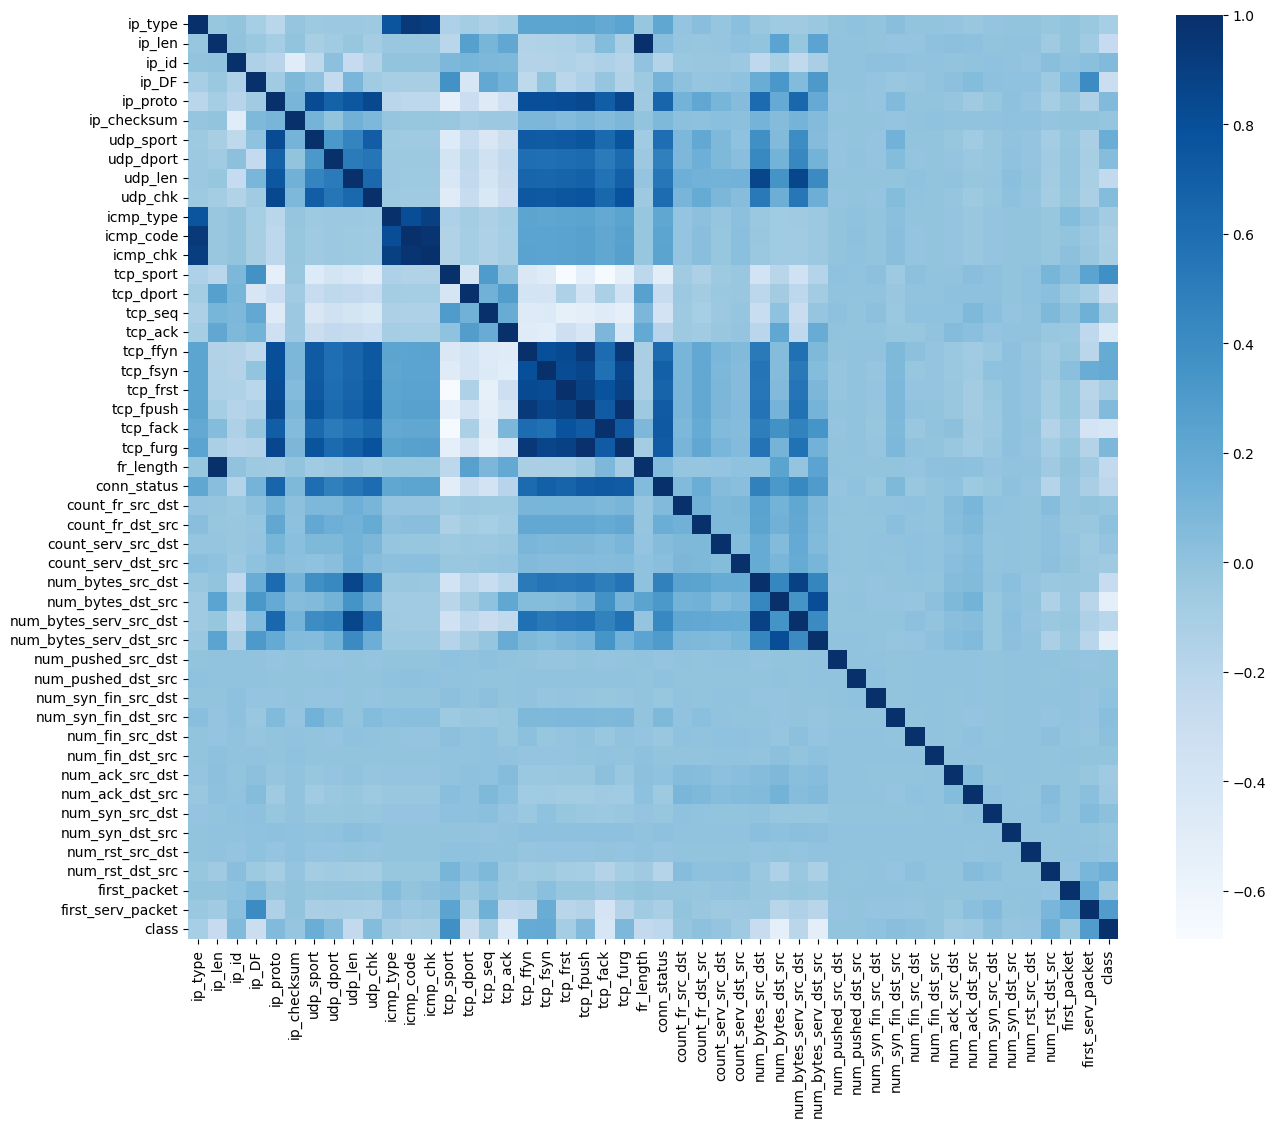

In [19]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="Blues")
plt.show()

In [20]:
corr["class"].sort_values(ascending=False)

class                     1.000000
tcp_sport                 0.376711
first_serv_packet         0.288401
tcp_fsyn                  0.183862
tcp_ffyn                  0.179369
udp_sport                 0.159150
num_rst_dst_src           0.148479
tcp_furg                  0.081623
ip_id                     0.070370
ip_proto                  0.068846
tcp_fpush                 0.068064
udp_chk                   0.050838
udp_dport                 0.043169
num_syn_fin_dst_src       0.032562
num_syn_src_dst           0.023503
num_fin_src_dst           0.018179
count_fr_dst_src          0.016557
num_syn_fin_src_dst       0.010139
num_pushed_src_dst       -0.005405
num_pushed_dst_src       -0.006834
num_fin_dst_src          -0.008403
num_rst_src_dst          -0.008925
count_serv_src_dst       -0.010181
ip_checksum              -0.015762
num_syn_dst_src          -0.017306
count_fr_src_dst         -0.018505
first_packet             -0.032560
num_ack_dst_src          -0.042007
num_ack_src_dst     

The target feature does not seem to have very strong correlations with any particular feature.

In [21]:
# remove all features with an absolute correlation of less than 0.1
cols_corr_gt1 = corr["class"][abs(corr["class"]) > 0.1].index

In [22]:
print(cols_corr_gt1)
print(len(cols_corr_gt1))

Index(['ip_len', 'ip_DF', 'udp_sport', 'udp_len', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_fack', 'fr_length', 'conn_status', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_rst_dst_src', 'first_serv_packet', 'class'], dtype='object')
21


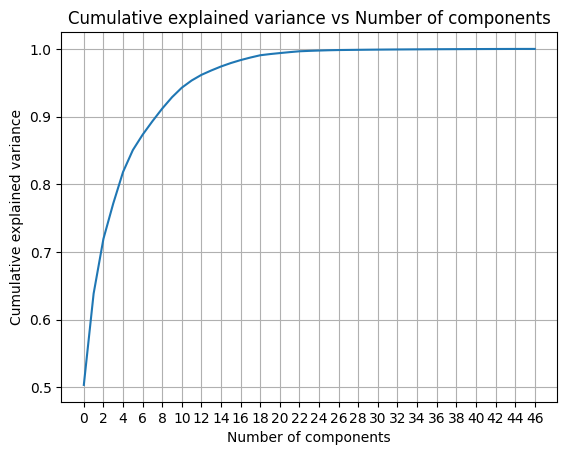

In [23]:
X = df.drop(columns=["class"])

#scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=len(df.columns) - 1)
X_pca = pca.fit_transform(X_scaled)

pca_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components")
plt.grid()
plt.xticks(range(0, len(df.columns) - 1, 2))
plt.show()

- at n=27, we have 95% of the variance explained

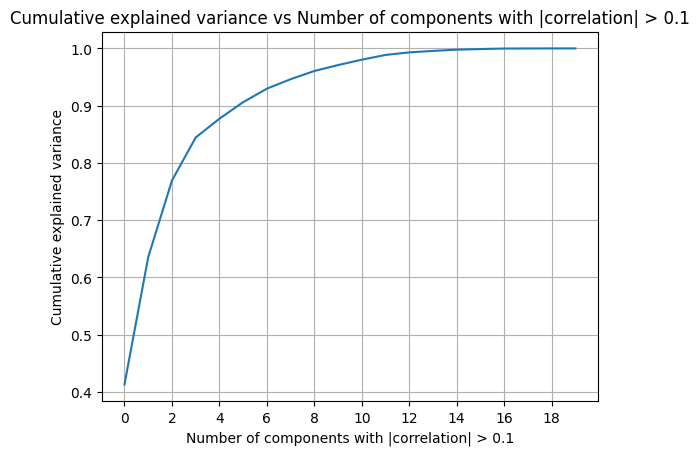

In [24]:
X_gt1 = df[cols_corr_gt1]
X_gt1 = X_gt1.drop(columns=["class"])

#scaler_gt1 = StandardScaler()
scaler_gt1 = MinMaxScaler()
X_gt1_scaled = scaler_gt1.fit_transform(X_gt1)

pca_corr_gt1 = PCA(n_components=len(cols_corr_gt1) - 1)
X_gt1_pca = pca_corr_gt1.fit_transform(X_gt1_scaled)

pca_cumsum = pca_corr_gt1.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components with |correlation| > 0.1")
plt.ylabel("Cumulative explained variance")
plt.title(
    "Cumulative explained variance vs Number of components with |correlation| > 0.1"
)
plt.grid()
plt.xticks(range(0, len(cols_corr_gt1) - 1, 2))
plt.show()

- at n=10 of the selected features, we have 95% of the variance explained

# Modelling

In [25]:
_, _, __X__, _, _, __y__ = test_train_val_split(df)
df_known_attacks = pd.DataFrame(__X__)
df_known_attacks["class"] = __y__
df_known_attacks.reset_index(drop=True, inplace=True)

In [26]:
df_similar_attacks = pd.read_csv(similar_attacks_path, low_memory=False)
df_similar_attacks = df_similar_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_similar_attacks["class"] = df_similar_attacks["class"].replace({"normal": 0, "attack": 1})

df_new_attacks = pd.read_csv(new_attacks_path, low_memory=False)
df_new_attacks = df_new_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_new_attacks["class"] = df_new_attacks["class"].replace({"normal": 0, "attack": 1})

In [27]:
if TESTING:
    df_similar_attacks = df_similar_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_similar_attacks.reset_index(drop=True, inplace=True)
    df_new_attacks = df_new_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_new_attacks.reset_index(drop=True, inplace=True)

In [28]:
def pipeline_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs:
        raise ValueError("df and scaler must be passed as keyword arguments for pipeline_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=df.columns[:-1])
    df_["class"] = df["class"]
    return df_

In [29]:
def pipeline_corr_gt1_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs:
        raise ValueError("df, scaler, and cols must be passed as keyword arguments for pipeline_corr_gt1_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]

    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=cols[:-1])
    df_["class"] = df["class"]
    return df_

In [30]:
def pipeline_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, and pca must be passed as keyword arguments for pipeline_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    pca = kwargs["pca"]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :27]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

In [31]:
def pipeline_corr_gt1_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, cols, and pca must be passed as keyword arguments for pipeline_corr_gt1_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]
    pca = kwargs["pca"]

    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :10]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

## Complement Naive Bayes

In [32]:
nb_params = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "force_alpha": [True, False],
    "fit_prior": [True, False],
    "norm": [True, False],
}

In [33]:
verbose = 3
cv = 3
n_jobs = None

### All features scaled

In [34]:
df_scaled = pipeline_scaled(df=df, scaler=scaler)
df_scaled.head()

,ip_type,ip_len,ip_id,ip_DF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,0.0,0.128431,0.213138,0.0,0.3125,0.750221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001223,0.835615,0.681178,0.648407,0.0,0.0,0.0,0.0,0.5,0.0,0.125860,0.357143,0.006272,0.008800,0.002673,0.006727,0.036546,0.25000,0.037876,0.25000,0.000013,0.0,0.0,0.0,0.0,0.0,0.003173,0.008776,0.000008,0.00001,0.0,0.0,0.0,0.0,0.0
1,0.0,0.128431,0.213153,0.0,0.3125,0.750206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001223,0.835615,0.681178,0.648407,0.0,0.0,0.0,0.0,0.5,0.0,0.125860,0.357143,0.006272,0.008815,0.002673,0.006739,0.036546,0.25000,0.037876,0.25000,0.000013,0.0,0.0,0.0,0.0,0.0,0.003173,0.008791,0.000008,0.00001,0.0,0.0,0.0,0.0,0.0
2,0.0,0.002941,0.395834,0.0,0.3125,0.675588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.894676,0.001223,0.000000,0.091918,0.0,0.0,0.0,0.0,0.5,0.0,0.001475,0.000000,0.000015,0.000000,0.000006,0.000000,0.000043,0.00000,0.000044,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000008,0.000000,0.000000,0.00000,0.0,0.0,1.0,1.0,1.0
3,0.0,0.005882,0.862516,1.0,0.3125,0.857494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857468,0.001223,0.001660,0.681273,0.0,0.0,0.0,0.0,0.5,0.0,0.002950,0.357143,0.000467,0.000562,0.000199,0.000430,0.003568,0.06453,0.003698,0.06453,0.000013,0.0,0.0,0.0,0.0,0.0,0.000229,0.000561,0.000008,0.00001,0.0,0.0,0.0,0.0,0.0
4,0.0,0.005882,0.418326,1.0,0.3125,0.302652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.835615,0.001223,0.648406,0.681178,0.0,0.0,0.0,0.0,0.5,0.0,0.002950,0.357143,0.006287,0.008815,0.002679,0.006739,0.036632,0.25000,0.037965,0.25000,0.000013,0.0,0.0,0.0,0.0,0.0,0.003181,0.008791,0.000008,0.00001,0.0,0.0,0.0,0.0,0.0


In [35]:
(
    X_scaled_train,
    X_scaled_val,
    X_scaled_test,
    y_scaled_train,
    y_scaled_val,
    y_scaled_test,
) = test_train_val_split(df_scaled)

In [36]:
nb_scaled_baseline = ComplementNB()
nb_scaled_baseline.fit(X_scaled_train, y_scaled_train)

ComplementNB()

In [37]:
print(classification_report(y_scaled_val, nb_scaled_baseline.predict(X_scaled_val)))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7154
         1.0       0.96      0.90      0.93      5605

    accuracy                           0.94     12759
   macro avg       0.94      0.94      0.94     12759
weighted avg       0.94      0.94      0.94     12759



In [38]:
nb_scaled_grid = GridSearchCV(ComplementNB(), nb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
nb_scaled_grid.fit(X_scaled_val, y_scaled_val)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV 1/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=True;, score=0.781 total time=   0.0s
[CV 2/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=True;, score=0.780 total time=   0.0s
[CV 3/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=True;, score=0.784 total time=   0.0s
[CV 1/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=False;, score=0.933 total time=   0.0s
[CV 2/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=False;, score=0.943 total time=   0.0s
[CV 3/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=False;, score=0.945 total time=   0.0s
[CV 1/3] END alpha=0.001, fit_prior=True, force_alpha=False, norm=True;, score=0.781 total time=   0.0s
[CV 2/3] END alpha=0.001, fit_prior=True, force_alpha=False, norm=True;, score=0.780 total time=   0.0s
[CV 3/3] END alpha=0.001, fit_prior=True, force_alpha=False, norm=True;, score=0.784 total time=   0.0s
[CV 1

[CV 3/3] END alpha=1, fit_prior=True, force_alpha=False, norm=True;, score=0.825 total time=   0.0s
[CV 1/3] END alpha=1, fit_prior=True, force_alpha=False, norm=False;, score=0.931 total time=   0.0s
[CV 2/3] END alpha=1, fit_prior=True, force_alpha=False, norm=False;, score=0.942 total time=   0.0s
[CV 3/3] END alpha=1, fit_prior=True, force_alpha=False, norm=False;, score=0.945 total time=   0.0s
[CV 1/3] END alpha=1, fit_prior=False, force_alpha=True, norm=True;, score=0.824 total time=   0.0s
[CV 2/3] END alpha=1, fit_prior=False, force_alpha=True, norm=True;, score=0.829 total time=   0.0s
[CV 3/3] END alpha=1, fit_prior=False, force_alpha=True, norm=True;, score=0.825 total time=   0.0s
[CV 1/3] END alpha=1, fit_prior=False, force_alpha=True, norm=False;, score=0.931 total time=   0.0s
[CV 2/3] END alpha=1, fit_prior=False, force_alpha=True, norm=False;, score=0.942 total time=   0.0s
[CV 3/3] END alpha=1, fit_prior=False, force_alpha=True, norm=False;, score=0.945 total time=  

GridSearchCV(cv=3, estimator=ComplementNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False], 'norm': [True, False]},
             verbose=3)

In [39]:
print(nb_scaled_grid.best_params_)

{'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}


In [40]:
nb_scaled = ComplementNB(**nb_scaled_grid.best_params_)
nb_scaled.fit(X_scaled_train, y_scaled_train)

ComplementNB(alpha=0.001, force_alpha=True)

In [41]:
print(classification_report(y_scaled_test, nb_scaled.predict(X_scaled_test)))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7209
         1.0       0.96      0.90      0.93      5550

    accuracy                           0.94     12759
   macro avg       0.94      0.94      0.94     12759
weighted avg       0.94      0.94      0.94     12759



In [42]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        nb_scaled,
        f"ComplementNB {nb_scaled_grid.best_params_}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler
        )

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7209
         1.0       0.96      0.90      0.93      5550

    accuracy                           0.94     12759
   macro avg       0.94      0.94      0.94     12759
weighted avg       0.94      0.94      0.94     12759


Model: ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Data size: 12759
Accuracy: 0.94027745121091
Precision: 0.9568702290076336
Recall: 0.9034234234234234
F1: 0.9293790546802595
Time per data per iter: 10.0519465


In [43]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        nb_scaled,
        f"ComplementNB {nb_scaled_grid.best_params_}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler
        )

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     15969
           1       0.97      0.96      0.96     10440

    accuracy                           0.97     26409
   macro avg       0.97      0.97      0.97     26409
weighted avg       0.97      0.97      0.97     26409


Model: ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Data size: 26409
Accuracy: 0.9721307130145026
Precision: 0.969336428709615
Recall: 0.9598659003831418
F1: 0.9645779189527385
Time per data per iter: 14.7592288


In [44]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        nb_scaled,
        f"ComplementNB {nb_scaled_grid.best_params_}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler
        )

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     58138
           1       0.74      0.18      0.29     17752

    accuracy                           0.79     75890
   macro avg       0.77      0.58      0.59     75890
weighted avg       0.78      0.79      0.74     75890


Model: ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Data size: 75890
Accuracy: 0.7942548425352484
Precision: 0.7437300501595987
Recall: 0.1837539432176656
F1: 0.2946969012557593
Time per data per iter: 37.3755759


In [45]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",Known attacks,All features scaled,12759,0.940277,0.956870,0.903423,0.929379,10.051946
1,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",Similar attacks,All features scaled,26409,0.972131,0.969336,0.959866,0.964578,14.759229
2,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",New attacks,All features scaled,75890,0.794255,0.743730,0.183754,0.294697,37.375576


### Features with |correlation| > 0.1 scaled

In [46]:
df_corr_gt1_scaled = pipeline_corr_gt1_scaled(df=df, scaler=scaler_gt1, cols=cols_corr_gt1)
df_corr_gt1_scaled.head()

,ip_len,ip_DF,udp_sport,udp_len,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_fack,fr_length,conn_status,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_rst_dst_src,first_serv_packet,class
0,0.128431,0.0,0.0,0.0,0.0,0.0,0.001223,0.835615,0.648407,0.0,0.0,0.5,0.125860,0.357143,0.036546,0.25000,0.037876,0.25000,0.0,0.0,0.0
1,0.128431,0.0,0.0,0.0,0.0,0.0,0.001223,0.835615,0.648407,0.0,0.0,0.5,0.125860,0.357143,0.036546,0.25000,0.037876,0.25000,0.0,0.0,0.0
2,0.002941,0.0,0.0,0.0,0.0,0.0,0.894676,0.001223,0.091918,0.0,0.0,0.5,0.001475,0.000000,0.000043,0.00000,0.000044,0.00000,0.0,1.0,1.0
3,0.005882,1.0,0.0,0.0,0.0,0.0,0.857468,0.001223,0.681273,0.0,0.0,0.5,0.002950,0.357143,0.003568,0.06453,0.003698,0.06453,0.0,0.0,0.0
4,0.005882,1.0,0.0,0.0,0.0,0.0,0.835615,0.001223,0.681178,0.0,0.0,0.5,0.002950,0.357143,0.036632,0.25000,0.037965,0.25000,0.0,0.0,0.0


In [47]:
(
    X_corr_gt1_scaled_train,
    X_corr_gt1_scaled_val,
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_train,
    y_corr_gt1_scaled_val,
    y_corr_gt1_scaled_test,
) = test_train_val_split(df_corr_gt1_scaled)

In [48]:
nb_corr_gt1_scaled_baseline = ComplementNB()
nb_corr_gt1_scaled_baseline.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

ComplementNB()

In [49]:
print(classification_report(y_corr_gt1_scaled_val, nb_corr_gt1_scaled_baseline.predict(X_corr_gt1_scaled_val)))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7154
         1.0       0.96      0.91      0.93      5605

    accuracy                           0.94     12759
   macro avg       0.95      0.94      0.94     12759
weighted avg       0.94      0.94      0.94     12759



In [50]:
nb_corr_gt1_scaled_grid = GridSearchCV(ComplementNB(), nb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
nb_corr_gt1_scaled_grid.fit(X_corr_gt1_scaled_val, y_corr_gt1_scaled_val)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV 1/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=True;, score=0.775 total time=   0.0s
[CV 2/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=True;, score=0.765 total time=   0.0s
[CV 3/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=True;, score=0.764 total time=   0.0s
[CV 1/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=False;, score=0.940 total time=   0.0s
[CV 2/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=False;, score=0.946 total time=   0.0s
[CV 3/3] END alpha=0.001, fit_prior=True, force_alpha=True, norm=False;, score=0.946 total time=   0.0s
[CV 1/3] END alpha=0.001, fit_prior=True, force_alpha=False, norm=True;, score=0.775 total time=   0.0s
[CV 2/3] END alpha=0.001, fit_prior=True, force_alpha=False, norm=True;, score=0.765 total time=   0.0s
[CV 3/3] END alpha=0.001, fit_prior=True, force_alpha=False, norm=True;, score=0.764 total time=   0.0s
[CV 1

[CV 2/3] END alpha=1, fit_prior=True, force_alpha=False, norm=True;, score=0.782 total time=   0.0s
[CV 3/3] END alpha=1, fit_prior=True, force_alpha=False, norm=True;, score=0.779 total time=   0.0s
[CV 1/3] END alpha=1, fit_prior=True, force_alpha=False, norm=False;, score=0.940 total time=   0.0s
[CV 2/3] END alpha=1, fit_prior=True, force_alpha=False, norm=False;, score=0.946 total time=   0.0s
[CV 3/3] END alpha=1, fit_prior=True, force_alpha=False, norm=False;, score=0.946 total time=   0.0s
[CV 1/3] END alpha=1, fit_prior=False, force_alpha=True, norm=True;, score=0.781 total time=   0.0s
[CV 2/3] END alpha=1, fit_prior=False, force_alpha=True, norm=True;, score=0.782 total time=   0.0s
[CV 3/3] END alpha=1, fit_prior=False, force_alpha=True, norm=True;, score=0.779 total time=   0.0s
[CV 1/3] END alpha=1, fit_prior=False, force_alpha=True, norm=False;, score=0.940 total time=   0.0s
[CV 2/3] END alpha=1, fit_prior=False, force_alpha=True, norm=False;, score=0.946 total time=   

GridSearchCV(cv=3, estimator=ComplementNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False], 'norm': [True, False]},
             verbose=3)

In [51]:
print(nb_corr_gt1_scaled_grid.best_params_)

{'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}


In [52]:
nb_corr_gt1_scaled = ComplementNB(**nb_corr_gt1_scaled_grid.best_params_)
nb_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

ComplementNB(alpha=0.001, force_alpha=True)

In [53]:
print(classification_report(y_corr_gt1_scaled_test, nb_corr_gt1_scaled.predict(X_corr_gt1_scaled_test)))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7209
         1.0       0.96      0.91      0.93      5550

    accuracy                           0.94     12759
   macro avg       0.95      0.94      0.94     12759
weighted avg       0.94      0.94      0.94     12759



In [54]:
benchmark_util.benchmarkAndUpdateResult(
        df_known_attacks,
        nb_corr_gt1_scaled,
        f"ComplementNB {nb_corr_gt1_scaled_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      7209
         1.0       0.96      0.91      0.93      5550

    accuracy                           0.94     12759
   macro avg       0.95      0.94      0.94     12759
weighted avg       0.94      0.94      0.94     12759


Model: ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Data size: 12759
Accuracy: 0.9441962536248922
Precision: 0.9618174875906834
Recall: 0.9077477477477478
F1: 0.9340007415647016
Time per data per iter: 8.6747145


In [55]:
benchmark_util.benchmarkAndUpdateResult(
        df_similar_attacks,
        nb_corr_gt1_scaled,
        f"ComplementNB {nb_corr_gt1_scaled_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15969
           1       0.98      0.97      0.97     10440

    accuracy                           0.98     26409
   macro avg       0.98      0.98      0.98     26409
weighted avg       0.98      0.98      0.98     26409


Model: ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Data size: 26409
Accuracy: 0.9775076678405089
Precision: 0.9750096487842532
Recall: 0.967911877394636
F1: 0.9714477985002885
Time per data per iter: 13.569607


In [56]:
benchmark_util.benchmarkAndUpdateResult(
        df_new_attacks,
        nb_corr_gt1_scaled,
        f"ComplementNB {nb_corr_gt1_scaled_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     58138
           1       0.80      0.17      0.28     17752

    accuracy                           0.80     75890
   macro avg       0.80      0.58      0.58     75890
weighted avg       0.80      0.80      0.74     75890


Model: ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Data size: 75890
Accuracy: 0.7962840954012387
Precision: 0.799373040752351
Recall: 0.17237494366831907
F1: 0.283595922150139
Time per data per iter: 25.235258899999998


In [57]:
benchmark_util.display()

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",Known attacks,All features scaled,12759,0.940277,0.956870,0.903423,0.929379,10.051946
1,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",Similar attacks,All features scaled,26409,0.972131,0.969336,0.959866,0.964578,14.759229
2,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",New attacks,All features scaled,75890,0.794255,0.743730,0.183754,0.294697,37.375576
3,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",Known attacks,|correlation| > 0.1 features scaled,12759,0.944196,0.961817,0.907748,0.934001,8.674715
4,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",Similar attacks,|correlation| > 0.1 features scaled,26409,0.977508,0.975010,0.967912,0.971448,13.569607
5,"ComplementNB {'alpha': 0.001, 'fit_prior': True, 'force_alpha': True, 'norm': False}",New attacks,|correlation| > 0.1 features scaled,75890,0.796284,0.799373,0.172375,0.283596,25.235259


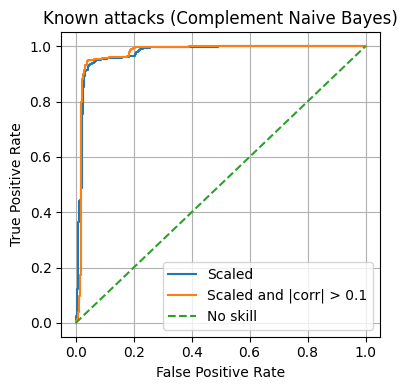

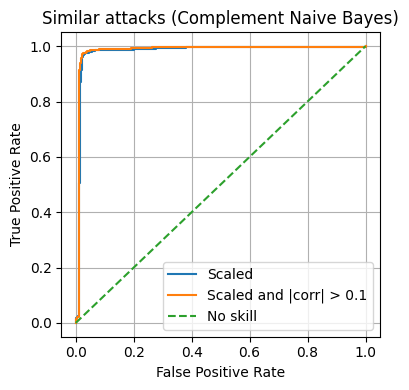

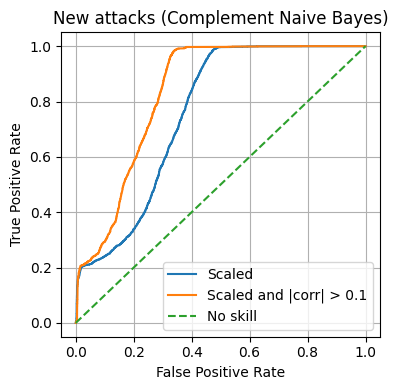

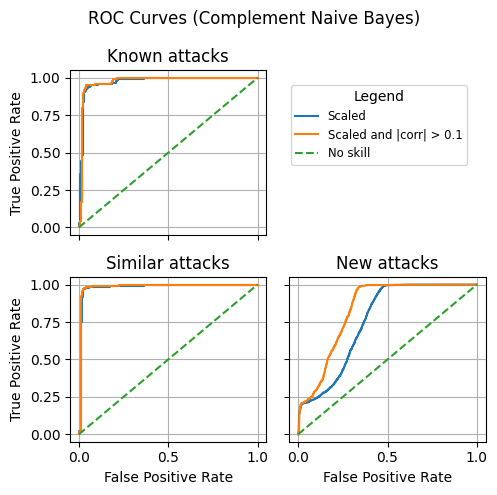

In [58]:
model_name = "Complement Naive Bayes"
clf = ComplementNB
clf_scaled_grid = nb_scaled_grid
clf_corr_gt1_scaled_grid = nb_corr_gt1_scaled_grid

#####

figure_path = f"{prepend_path}/report/figures/"
import os
from sklearn.metrics import roc_curve
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

clf_scaled = clf(**clf_scaled_grid.best_params_)
clf_scaled.fit(X_scaled_train, y_scaled_train)

clf_corr_gt1_scaled = clf(**clf_corr_gt1_scaled_grid.best_params_)
clf_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

df_scaled_roc1 = pipeline_scaled(df=df_known_attacks, scaler=scaler)
_, _, X_known_attacks_scaled, _, _, y_known_attacks_scaled = test_train_val_split(df_scaled_roc1)
y_known_attacks_scaled_pred = clf_scaled.predict_proba(X_known_attacks_scaled)

df_corr_gt1_scaled_roc1 = pipeline_corr_gt1_scaled(df=df_known_attacks, scaler=scaler_gt1, cols=cols_corr_gt1)
_, _, X_known_attacks_corr_gt1_scaled, _, _, y_known_attacks_corr_gt1_scaled = test_train_val_split(df_corr_gt1_scaled_roc1)
y_known_attacks_corr_gt1_scaled_pred = clf_corr_gt1_scaled.predict_proba(X_known_attacks_corr_gt1_scaled)

df_scaled_roc = pipeline_scaled(df=df_similar_attacks, scaler=scaler)
_, _, X_similar_attacks_scaled, _, _, y_similar_attacks_scaled = test_train_val_split(df_scaled_roc)
y_similar_attacks_scaled_pred = clf_scaled.predict_proba(X_similar_attacks_scaled)

df_corr_gt1_scaled_roc = pipeline_corr_gt1_scaled(df=df_similar_attacks, scaler=scaler_gt1, cols=cols_corr_gt1)
_, _, X_similar_attacks_corr_gt1_scaled, _, _, y_similar_attacks_corr_gt1_scaled = test_train_val_split(df_corr_gt1_scaled_roc)
y_similar_attacks_corr_gt1_scaled_pred = clf_corr_gt1_scaled.predict_proba(X_similar_attacks_corr_gt1_scaled)

df_scaled_roc2 = pipeline_scaled(df=df_new_attacks, scaler=scaler)
_, _, X_new_attacks_scaled, _, _, y_new_attacks_scaled = test_train_val_split(df_scaled_roc2)
y_new_attacks_scaled_pred = clf_scaled.predict_proba(X_new_attacks_scaled)

df_corr_gt1_scaled_roc2 = pipeline_corr_gt1_scaled(df=df_new_attacks, scaler=scaler_gt1, cols=cols_corr_gt1)
_, _, X_new_attacks_corr_gt1_scaled, _, _, y_new_attacks_corr_gt1_scaled = test_train_val_split(df_corr_gt1_scaled_roc2)
y_new_attacks_corr_gt1_scaled_pred = clf_corr_gt1_scaled.predict_proba(X_new_attacks_corr_gt1_scaled)

fpr_scaled1, tpr_scaled1, _ = roc_curve(y_known_attacks_scaled, y_known_attacks_scaled_pred[:, 1])
fpr_corr_gt1_scaled1, tpr_corr_gt1_scaled1, _ = roc_curve(y_known_attacks_corr_gt1_scaled, y_known_attacks_corr_gt1_scaled_pred[:, 1])

fpr_scaled, tpr_scaled, _ = roc_curve(y_similar_attacks_scaled, y_similar_attacks_scaled_pred[:, 1])
fpr_corr_gt1_scaled, tpr_corr_gt1_scaled, _ = roc_curve(y_similar_attacks_corr_gt1_scaled, y_similar_attacks_corr_gt1_scaled_pred[:, 1])

fpr_scaled2, tpr_scaled2, _ = roc_curve(y_new_attacks_scaled, y_new_attacks_scaled_pred[:, 1])
fpr_corr_gt1_scaled2, tpr_corr_gt1_scaled2, _ = roc_curve(y_new_attacks_corr_gt1_scaled, y_new_attacks_corr_gt1_scaled_pred[:, 1])
figsize = (4,4)

plt.figure(figsize=figsize)
plt.plot(fpr_scaled1, tpr_scaled1, label="Scaled")
plt.plot(fpr_corr_gt1_scaled1, tpr_corr_gt1_scaled1, label="Scaled and |corr| > 0.1")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title(f"Known attacks ({model_name})")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_known_attacks_roc.png")
plt.show()

plt.figure(figsize=figsize)
plt.plot(fpr_scaled, tpr_scaled, label="Scaled")
plt.plot(fpr_corr_gt1_scaled, tpr_corr_gt1_scaled, label="Scaled and |corr| > 0.1")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Similar attacks ({model_name})")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_similar_attacks_roc.png")
plt.show()

plt.figure(figsize=figsize)
plt.plot(fpr_scaled2, tpr_scaled2, label="Scaled")
plt.plot(fpr_corr_gt1_scaled2, tpr_corr_gt1_scaled2, label="Scaled and |corr| > 0.1")
plt.plot([0, 1], [0, 1], linestyle="--", label="No skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"New attacks ({model_name})")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_new_attacks_roc.png")
plt.show()

figsize = (5,5)
fig, axs = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)
ax=axs.flatten()
plt.suptitle(f"ROC Curves ({model_name})")

ax[0].plot(fpr_scaled1, tpr_scaled1, label="Scaled")
ax[0].plot(fpr_corr_gt1_scaled1, tpr_corr_gt1_scaled1, label="Scaled and |corr| > 0.1")
ax[0].plot([0, 1], [0, 1], linestyle="--", label="No skill")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title(f"Known attacks")
ax[0].grid()

ax[2].plot(fpr_scaled, tpr_scaled)
ax[2].plot(fpr_corr_gt1_scaled, tpr_corr_gt1_scaled)
ax[2].plot([0, 1], [0, 1], linestyle="--")
ax[2].set_xlabel("False Positive Rate")
ax[2].set_ylabel("True Positive Rate")
ax[2].set_title(f"Similar attacks")
ax[2].grid()

ax[3].plot(fpr_scaled2, tpr_scaled2)
ax[3].plot(fpr_corr_gt1_scaled2, tpr_corr_gt1_scaled2)
ax[3].plot([0, 1], [0, 1], linestyle="--")
ax[3].set_xlabel("False Positive Rate")
ax[3].set_title(f"New attacks")
ax[3].grid()

ax[1].axis("off")
fig.legend(loc="center", bbox_to_anchor=(0.75, 0.75), fontsize="small", title="Legend")

plt.tight_layout()
plt.savefig(f"{figure_path}/{model_name}_roc_all_small.png")
plt.show()